# Generating PSFs

This notebook demonstrates how to build a drizzle PSF using sample data included with *Mophongo*.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import importlib
from mophongo.psf import DrizzlePSF, PSF
from mophongo.templates import _convolve2d
from scipy.ndimage import shift
import mophongo.utils as utils
import mophongo.psf
importlib.reload(mophongo.psf)


<module 'mophongo.psf' from '/Users/ivo/Astro/PROJECTS/MOPHONGO/mophongo/mophongo/src/mophongo/psf.py'>

## Load the drizzle image and WCS info

In [ ]:
filt = 'F770W'
filter_regex = f'UDS_MIRI_{filt}'
# for NIRCam you would use e.g. filt = 'F444W'
filt = 'F115W'
#filter_regex = f'UDS_NRC.._{filt}'
filter_regex = f'STDPSF_NRC.._{filt}'
data_dir = Path('../data')
drz_file = data_dir / f'uds-test-{filt.lower()}_sci.fits'
csv_file = data_dir / f'uds-test-{filt.lower()}_wcs.csv'

psf_dir = data_dir / 'PSF'
dpsf = DrizzlePSF(driz_image=str(drz_file), csv_file=str(csv_file))
dpsf.epsf_obj.load_jwst_stdpsf(local_dir=str(psf_dir), filter_pattern=filter_regex, verbose=True)


Loading ../data/PSF/STDPSF_NRCB4_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCB3_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCB2_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCB1_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCA1_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCA2_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCA3_F115W_EXTENDED.fits
Loading ../data/PSF/STDPSF_NRCA4_F115W_EXTENDED.fits


## Extract a PSF at a chosen position

Cutout size: 15 pixels
Position: [549.84154333 738.03276282], Filter: STDPSF_NRCA1_F115W_EXTENDED, in frame: jw01837002005_04201_00001_nrca1_rate.fits[SCI,1]
Position: [602.96522386 755.25765025], Filter: STDPSF_NRCA1_F115W_EXTENDED, in frame: jw01837002005_04201_00002_nrca1_rate.fits[SCI,1]
Position: [711.48946528 966.17598915], Filter: STDPSF_NRCA3_F115W_EXTENDED, in frame: jw01837034001_05201_00001_nrca3_rate.fits[SCI,1]
Position: [764.77969303 983.00546733], Filter: STDPSF_NRCA3_F115W_EXTENDED, in frame: jw01837034001_05201_00002_nrca3_rate.fits[SCI,1]
Position: [ 264.71508831 1457.18565286], Filter: STDPSF_NRCB3_F115W_EXTENDED, in frame: jw03990063001_03201_00001_nrcb3_rate.fits[SCI,1]
Position: [ 253.49774904 1444.24076624], Filter: STDPSF_NRCB3_F115W_EXTENDED, in frame: jw03990063001_03201_00002_nrcb3_rate.fits[SCI,1]
Position: [ 275.83997745 1470.16605045], Filter: STDPSF_NRCB3_F115W_EXTENDED, in frame: jw03990063001_03201_00003_nrcb3_rate.fits[SCI,1]
Position: [962.09644044 27

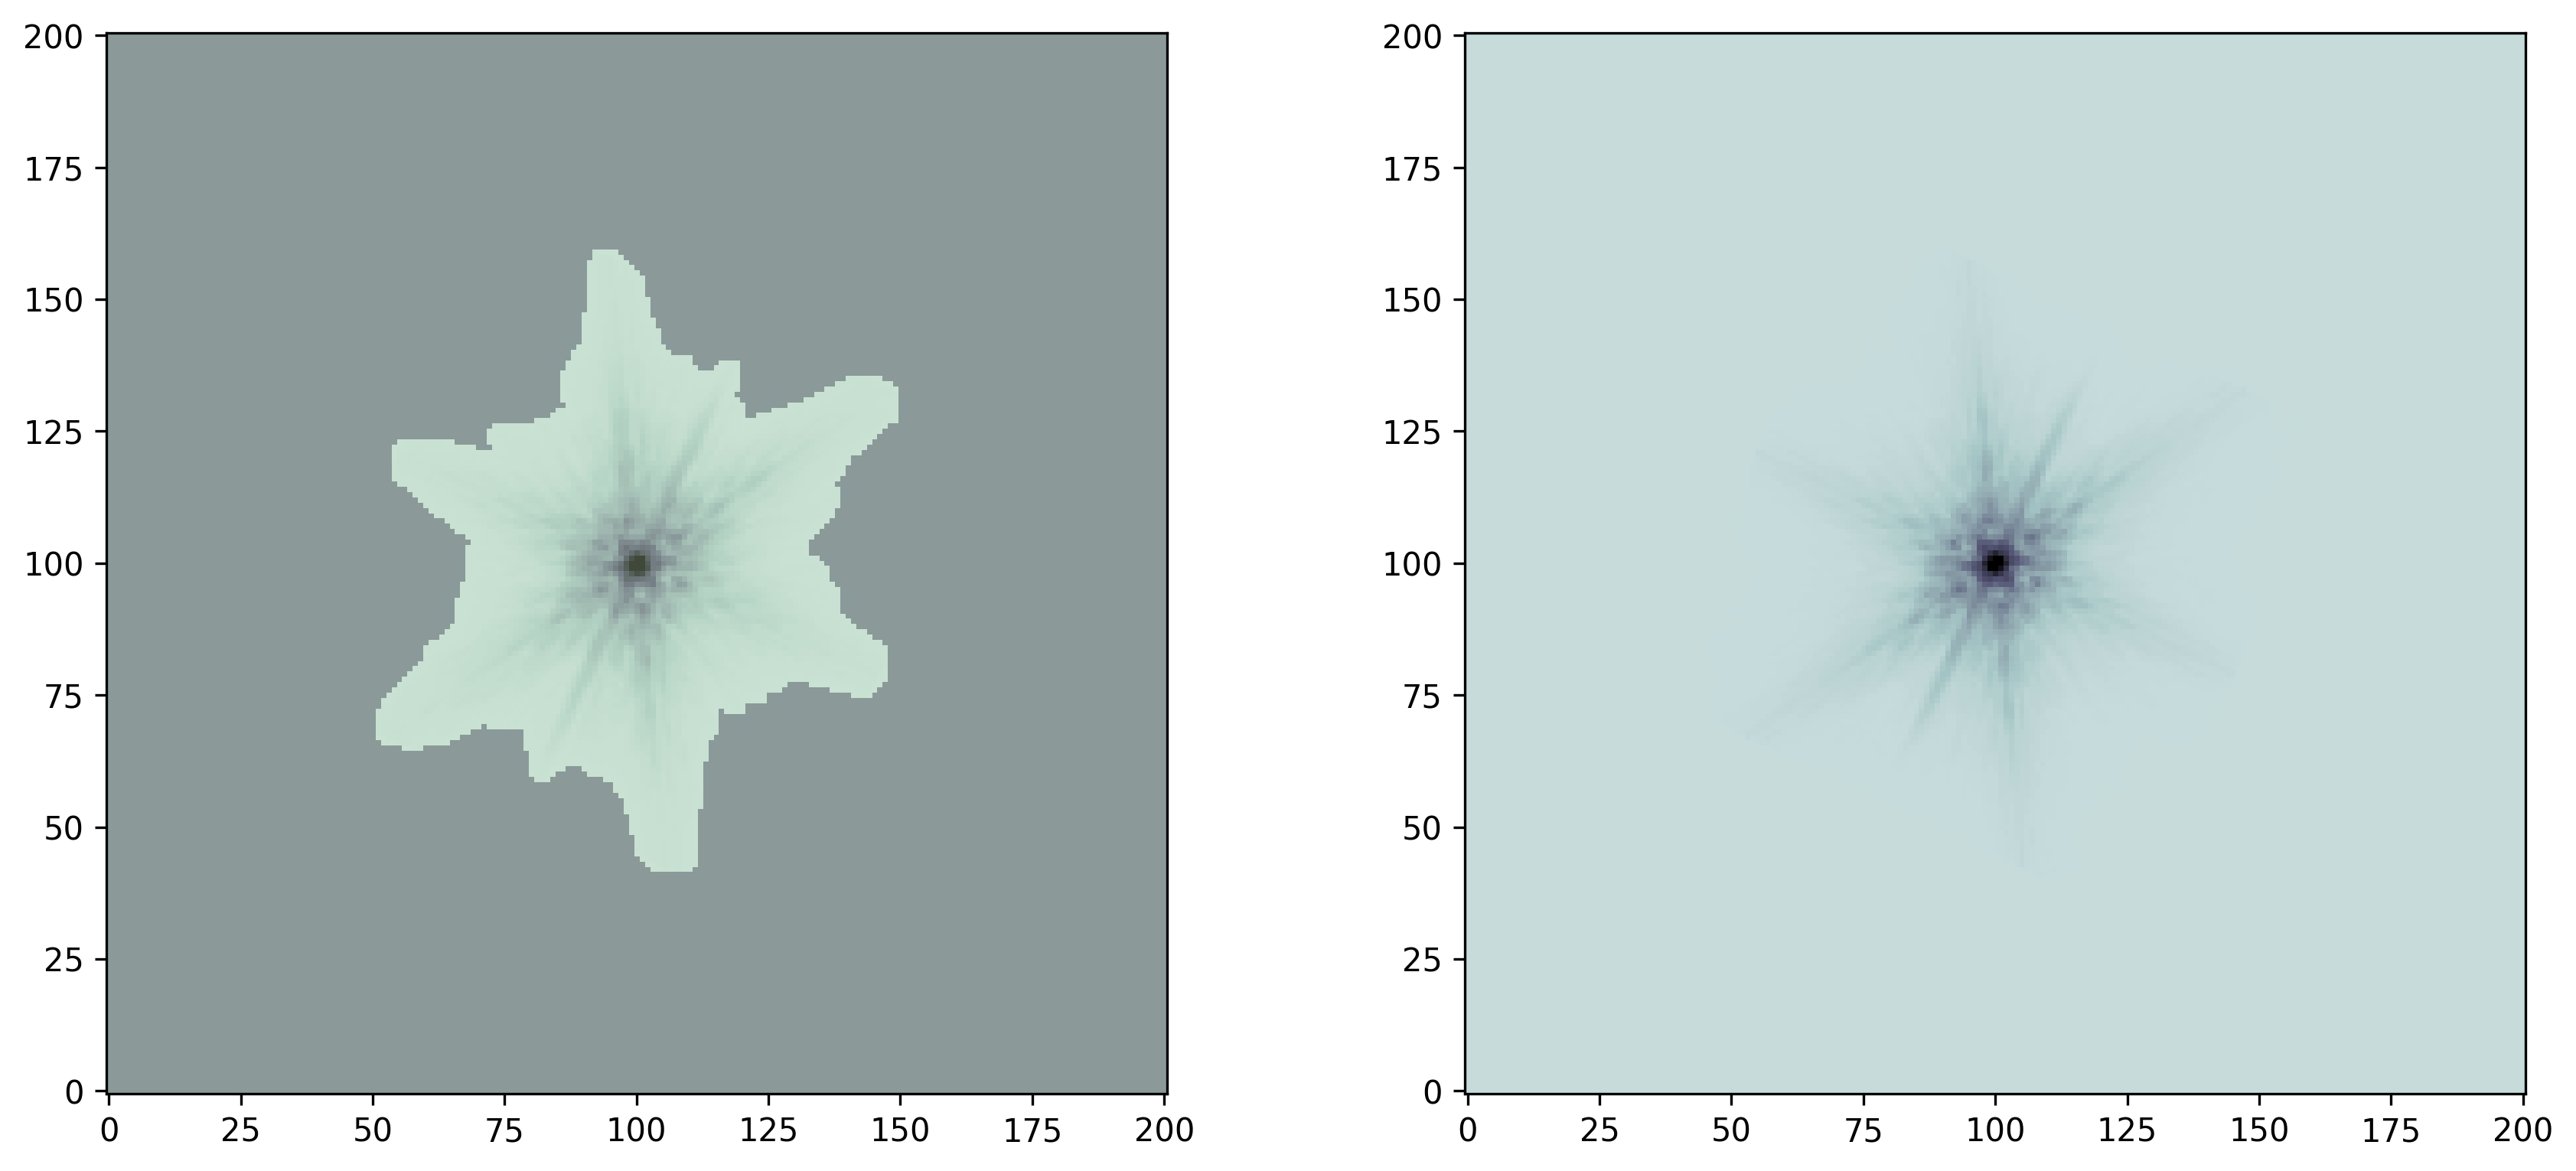

subtracted bg_level: 0.0
Mean: 0.004970176479208511, Median: 0.0037885767071404383, Std: 0.010889707612487243


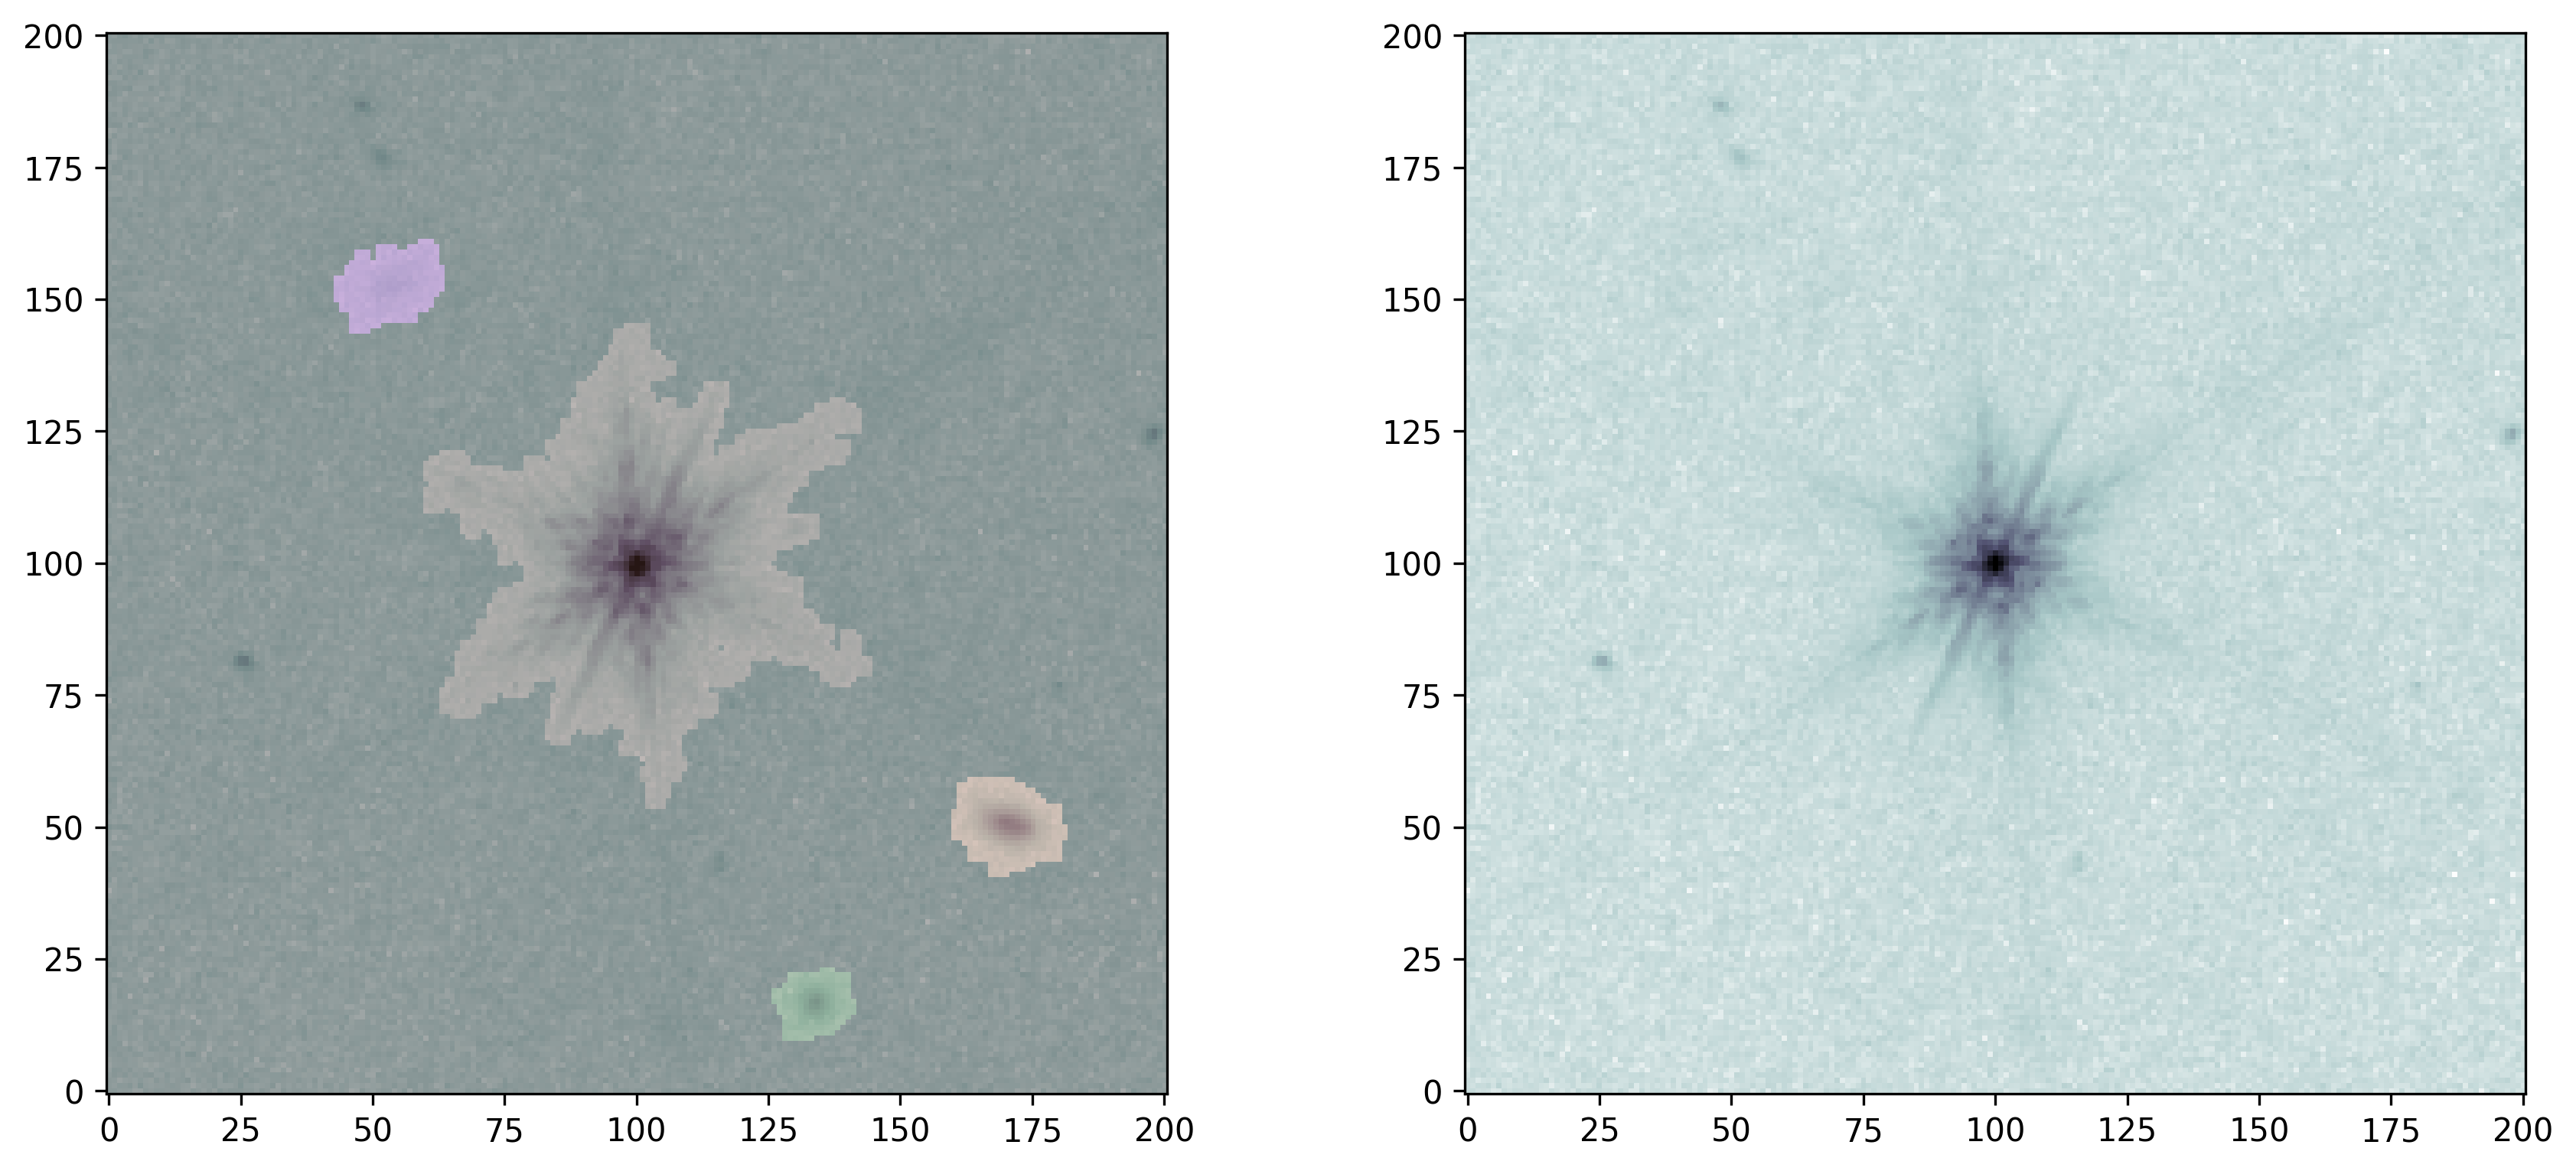

subtracted bg_level: 0.003353031352162361


In [ ]:
#ra, dec = 34.298227, -5.1262533
#ra, dec = 34.295937, -5.1294261
ra, dec = 34.30421, -5.1221624
size = 201
Rnorm_as = 1.5

cutout_reg = dpsf.get_driz_cutout(ra, dec, size=15, verbose=True, recenter=True)
pos_drz, _, _ = dpsf.register(cutout_reg, filter_regex, verbose=True)

cutout = dpsf.get_driz_cutout(ra, dec, size=size, verbose=True, recenter=True)
psf_data = dpsf.get_psf(
    ra=pos_drz[0], dec=pos_drz[1],
    filter=filter_regex, wcs_slice=cutout.wcs,
    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'],
)

from mophongo.utils import clean_stamp
psf_data, obj, bg_level = clean_stamp(psf_data, verbose=True, imshow=True)
cutout_data, obj, bg_level = clean_stamp(cutout.data, verbose=True, imshow=True)


## Match the PSF to the image and compare

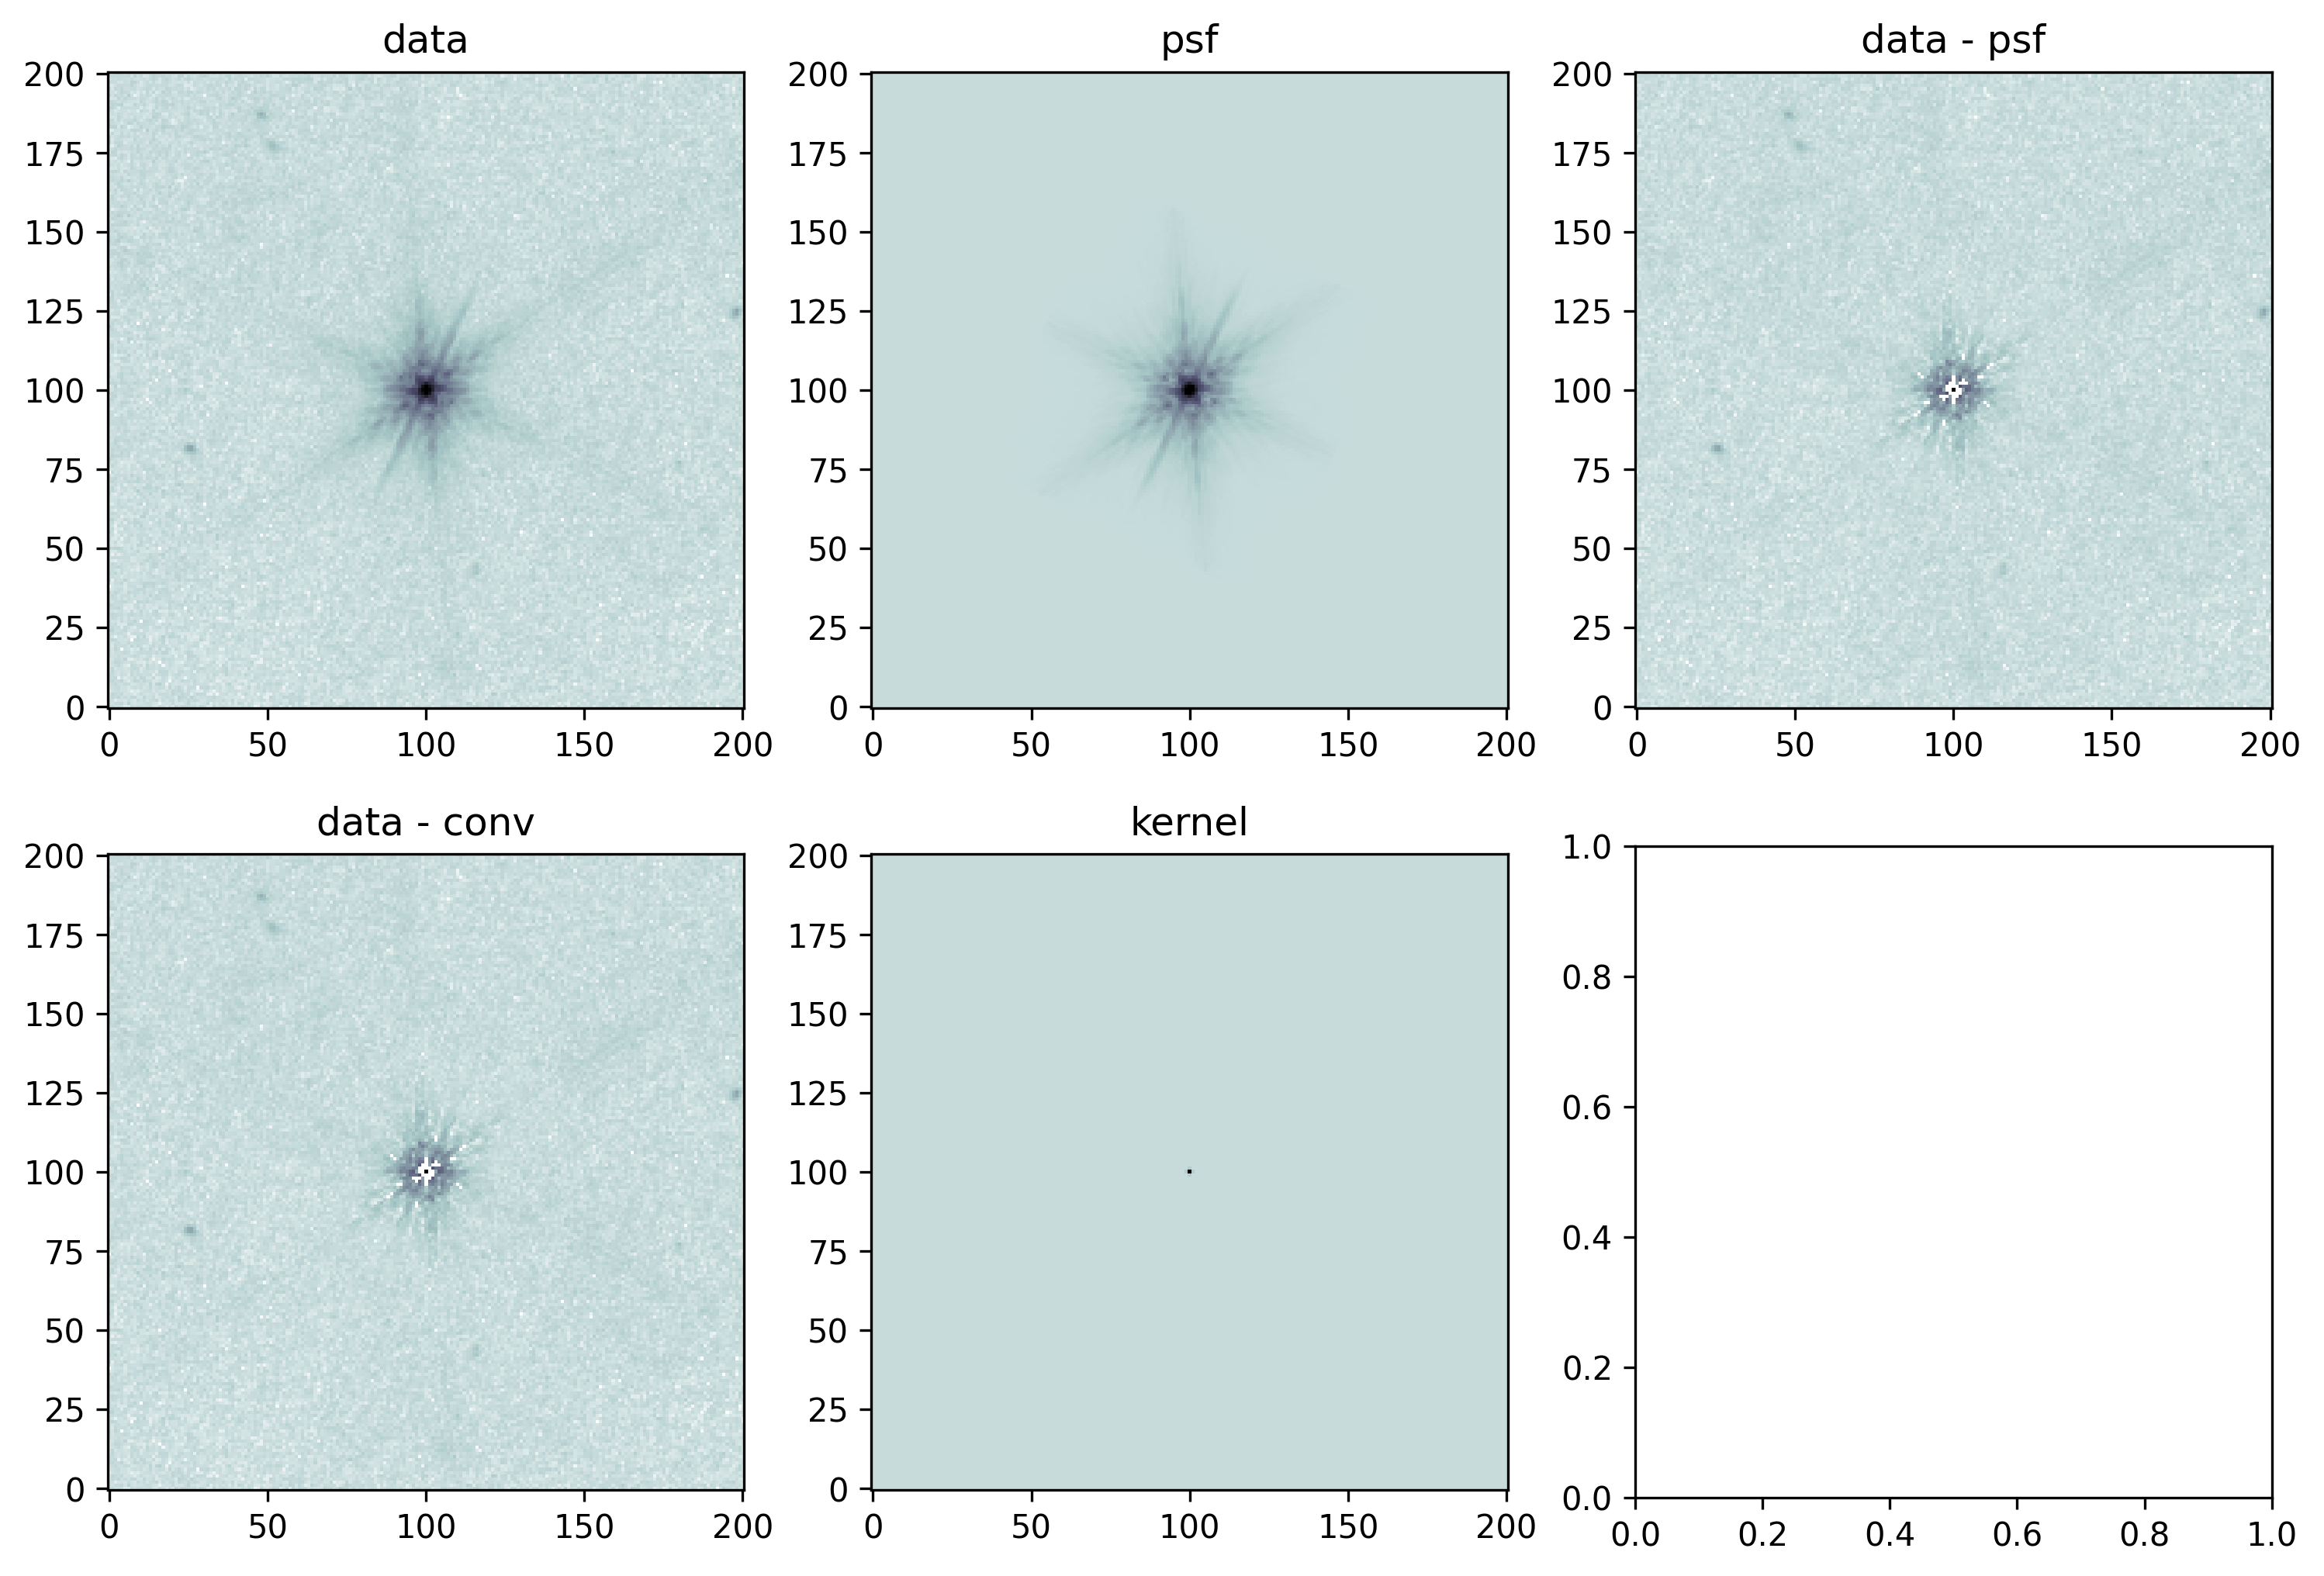

(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='Radius (pix)', ylabel='Normalized Profile'>,
        <Axes: xlabel='Radius (pix)', ylabel='Encircled Energy'>,
        <Axes: xlabel='Radius (pix)', ylabel='COG Ratio'>], dtype=object))

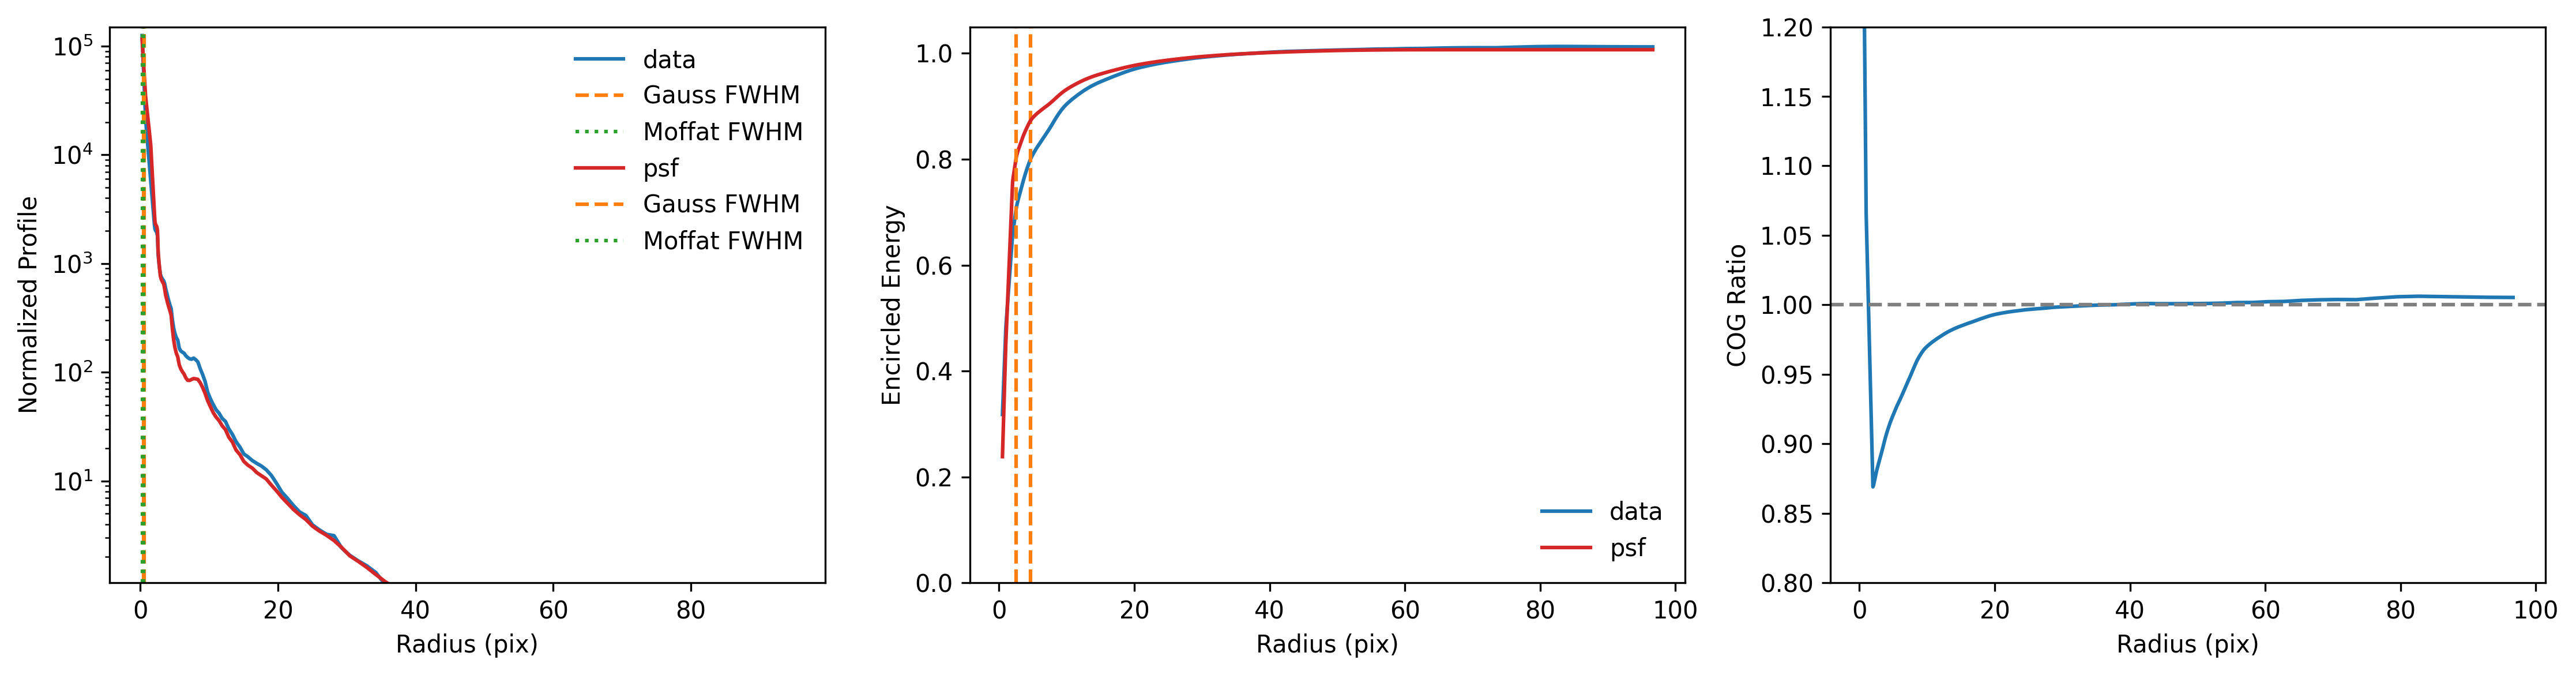

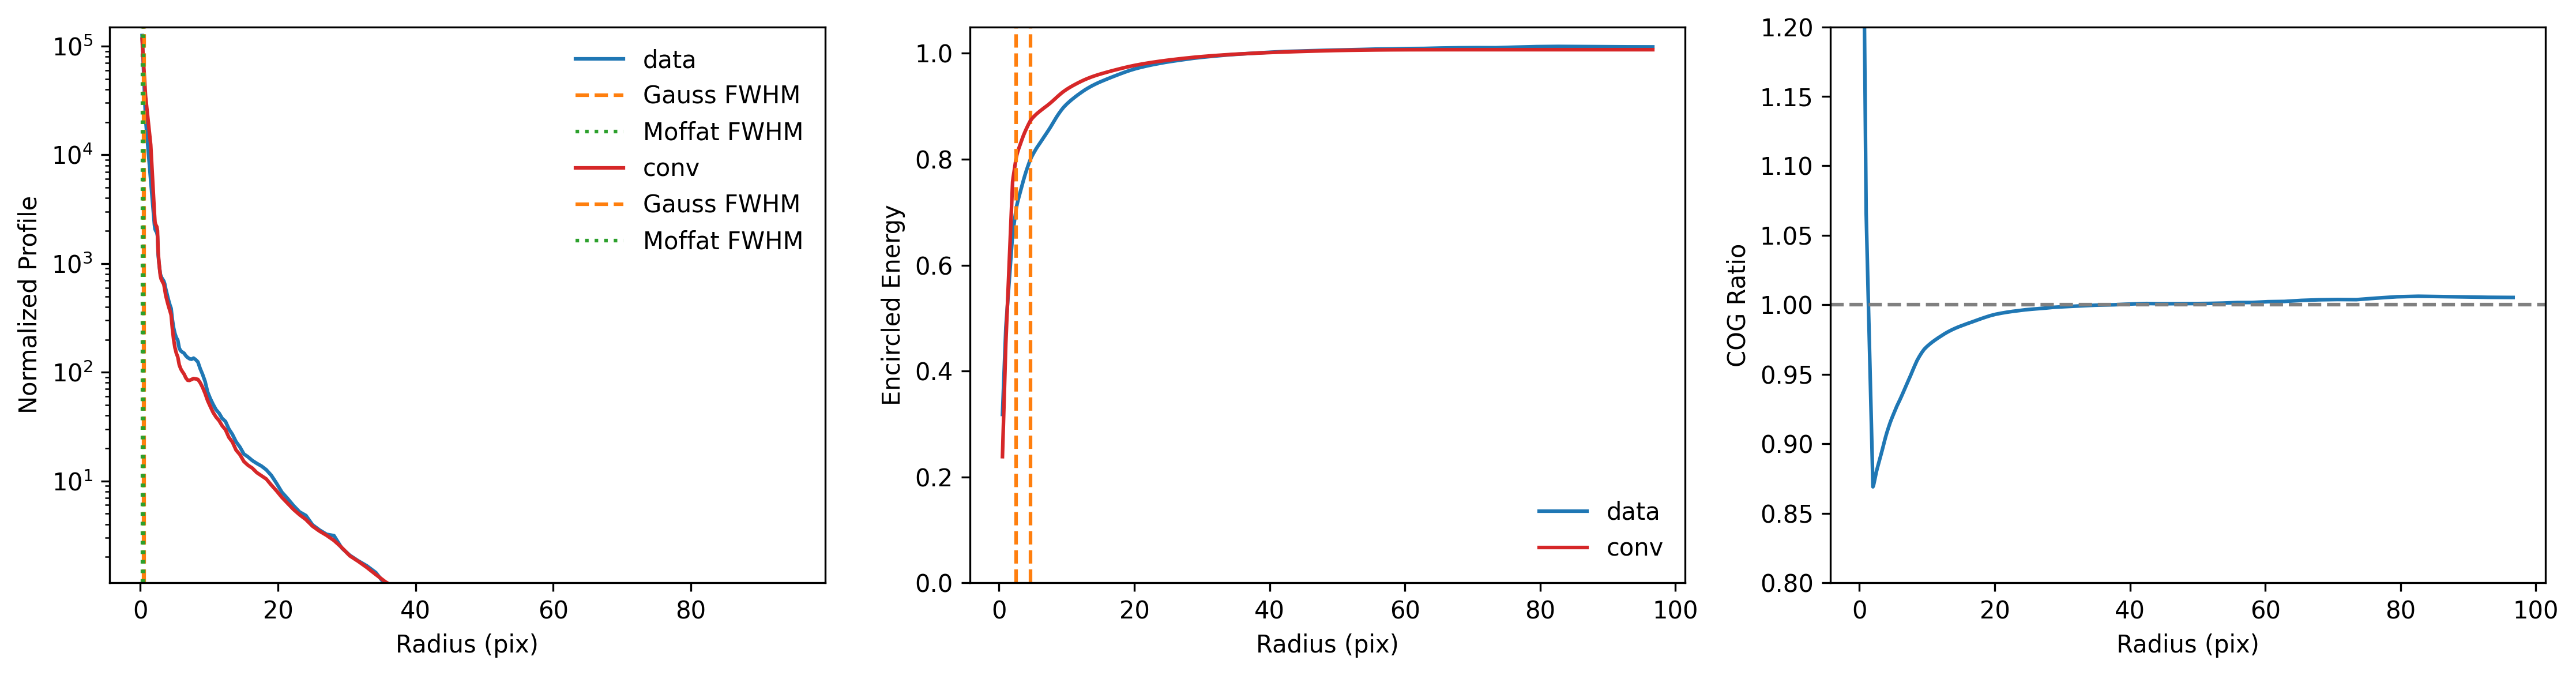

In [ ]:
mask = np.hypot(*np.indices(cutout_data.shape) - cutout_data.shape[0]//2) < (Rnorm_as / dpsf.driz_pscale)
scl = (cutout_data * psf_data)[mask].sum() / (psf_data[mask]**2).sum()

basis = utils.multi_gaussian_basis([0.5, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0], cutout_data.shape[0])
kernel, coeffs = utils.fit_kernel_fourier(psf_data, cutout_data, basis, method="nnls")
conv = _convolve2d(psf_data, kernel)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
offset = 2e-5
titles = ['data', 'psf', 'data - psf', 'data - conv', 'kernel']
kws = dict(vmin=-5.3, vmax=-1.5, cmap='bone_r', origin='lower')
axes[0].imshow(np.log10(cutout_data/scl + offset), **kws)
axes[1].imshow(np.log10(psf_data + offset), **kws)
axes[2].imshow(np.log10(cutout_data/scl - psf_data + offset), **kws)
axes[3].imshow(np.log10(cutout_data/scl - conv + offset), **kws)
axes[4].imshow(np.log10(kernel + offset), **kws)
axes[5].axis.axis('off')
for i in range(len(titles)):
    axes[i].set_title(titles[i])
plt.show()

recenter=True
rp_data = utils.CircularApertureProfile(cutout_data/scl, name='data', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=recenter)
rp_psf = utils.CircularApertureProfile(psf_data, name='psf', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=recenter)
rp_conv = utils.CircularApertureProfile(conv, name='conv', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=recenter)
rp_data.plot(compare_to=rp_psf)
rp_data.plot(compare_to=rp_conv)



In [26]:
i=1
#_=plt.imshow(basis.T[i])
basis.T[i].min(),basis.T[i].max() 

(np.float64(0.0), np.float64(0.3917201512933901))

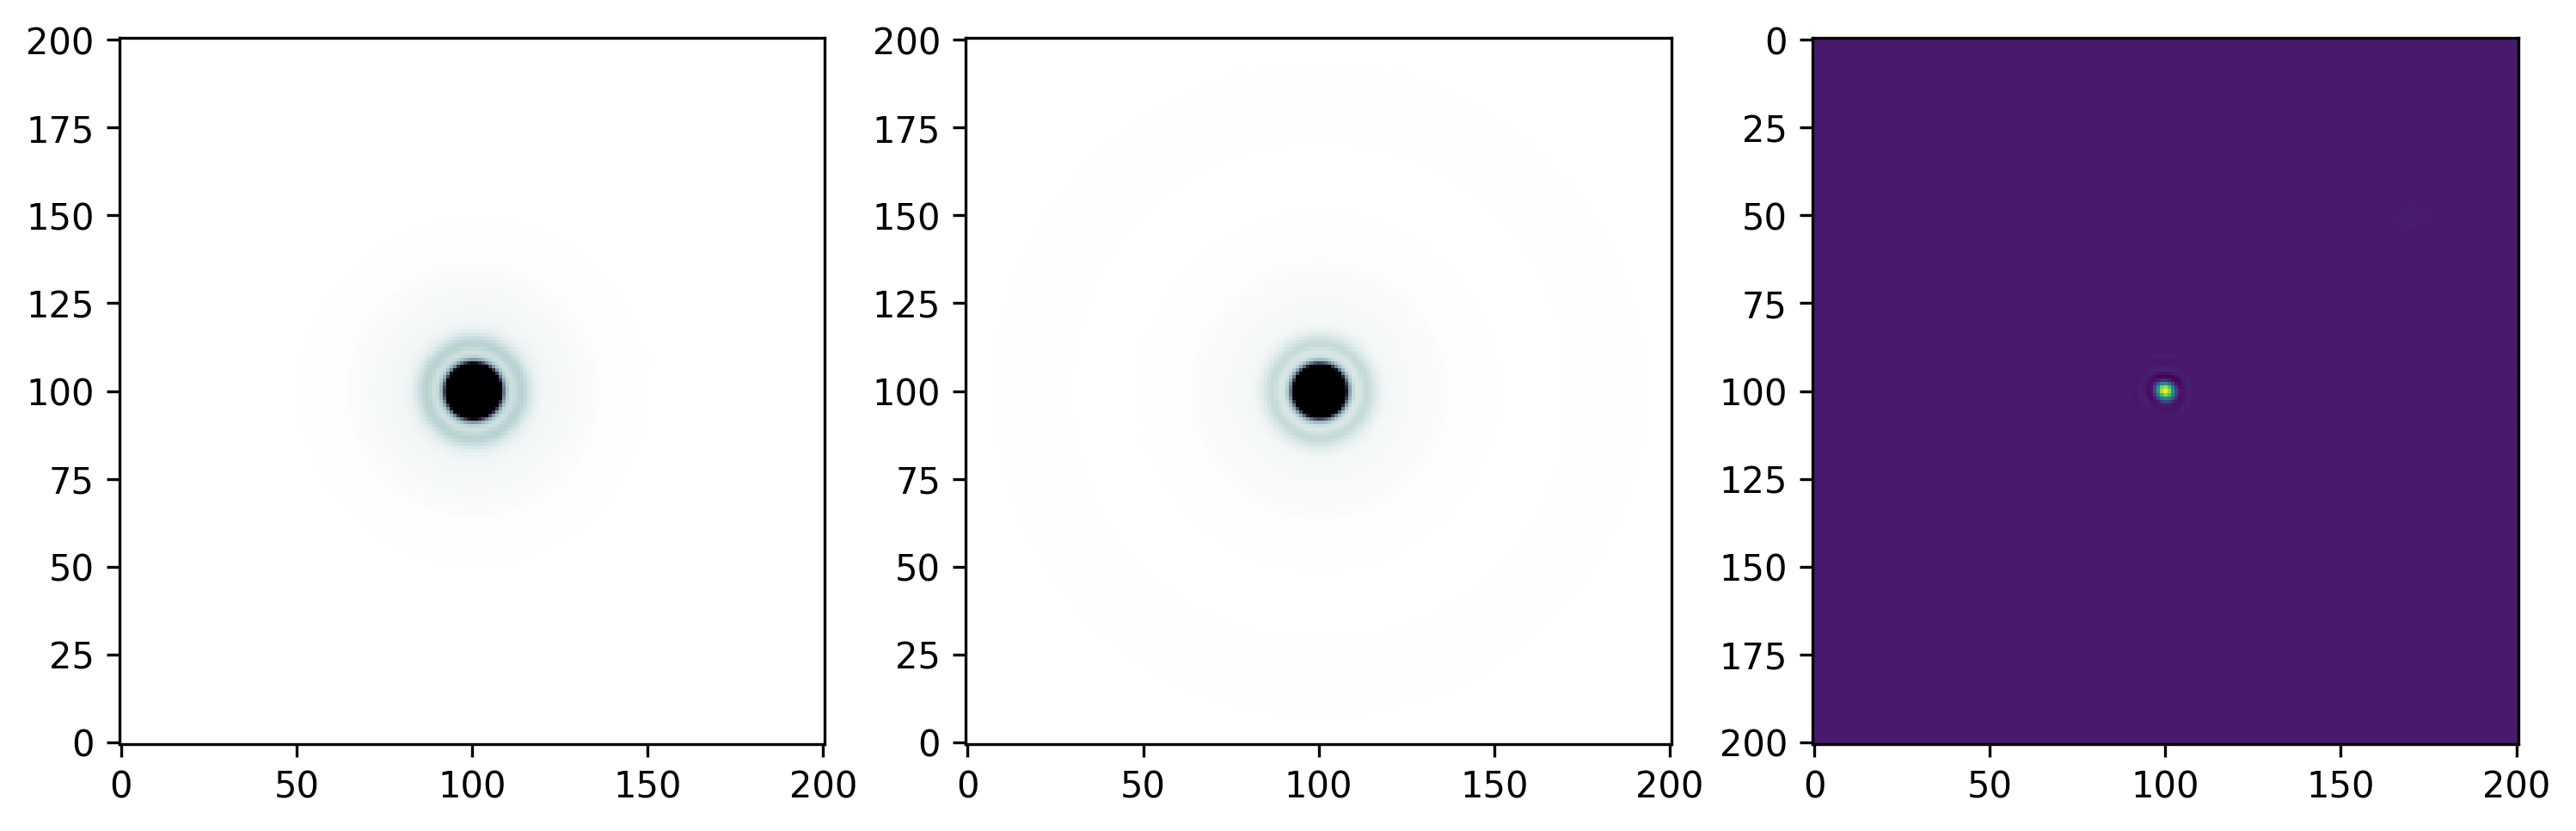

In [ ]:
from photutils.psf.matching import create_matching_kernel
from photutils.psf.matching import TukeyWindow, SplitCosineBellWindow
fig, ax = plt.subplots(1,3,figsize=(12, 4))
ap = rp_psf.apertures[10]
psf_radial = np.zeros_like(rp_psf.data)
for i,ap in enumerate(rp_psf.   apertures):
    psf_radial += ap.to_mask().to_image(rp_psf.data.shape) * rp_psf.profile[i]
ax[0].imshow(psf_radial,vmin=0.01, vmax=100, origin='lower', cmap='bone_r')
s
ap = rp_data.apertures[10
data_radial = np.zeros_like(rp_psf.data)
for i,ap in enumerate(rp_psf.apertures):
    data_radial += ap.to_mask().to_image(rp_psf.data.shape) * rp_data.profile[i]
ax[1].imshow(data_radial,vmin=0.01, vmax=100, origin='lower', cmap='bone_r')
#kernel = mophongo.psf.psf_matching_kernel(psf_radial, data_radial, window= SplitCosineBellWindow(alpha=0.3, beta=0.1))
kernel = mophongo.psf.psf_matching_kernel(psf_data, cutout_data/scl, window= SplitCosineBellWindow(alpha=0.5, beta=0.05))
ax[2].imshow(kernel)

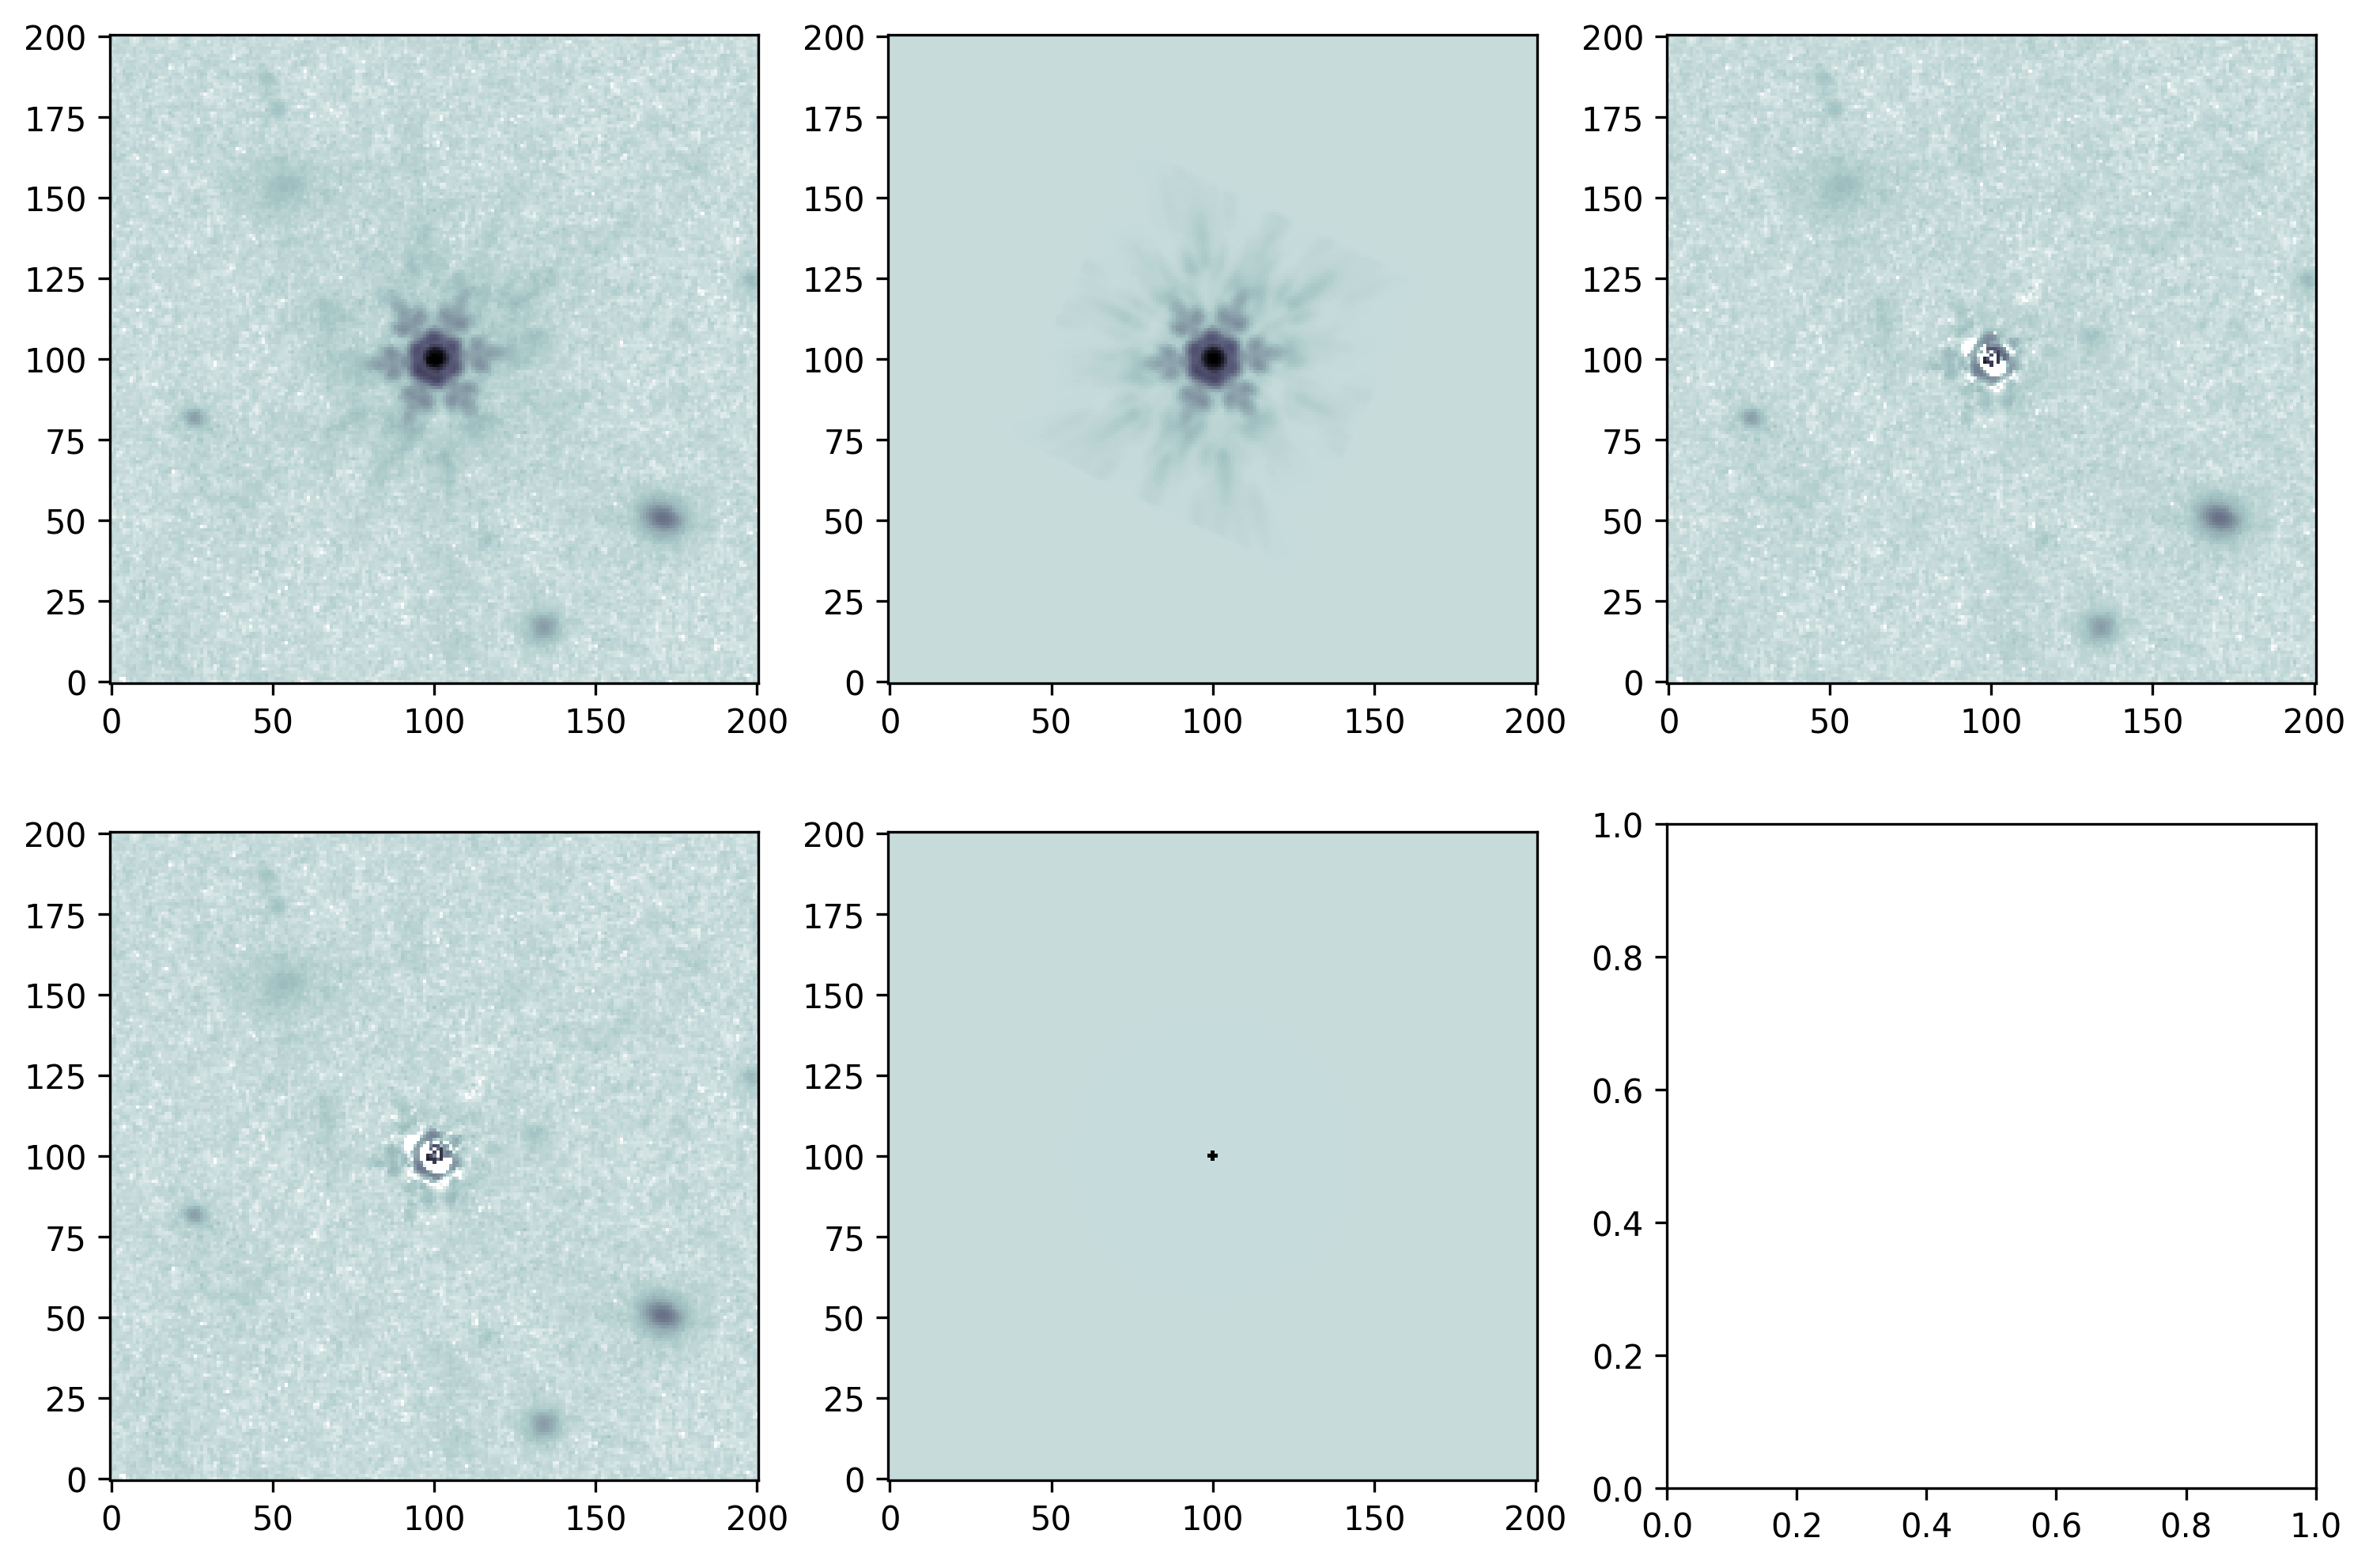

(<Figure size 4500x1200 with 3 Axes>,
 array([<Axes: xlabel='Radius (pix)', ylabel='Normalized Profile'>,
        <Axes: xlabel='Radius (pix)', ylabel='Encircled Energy'>,
        <Axes: xlabel='Radius (pix)', ylabel='COG Ratio'>], dtype=object))

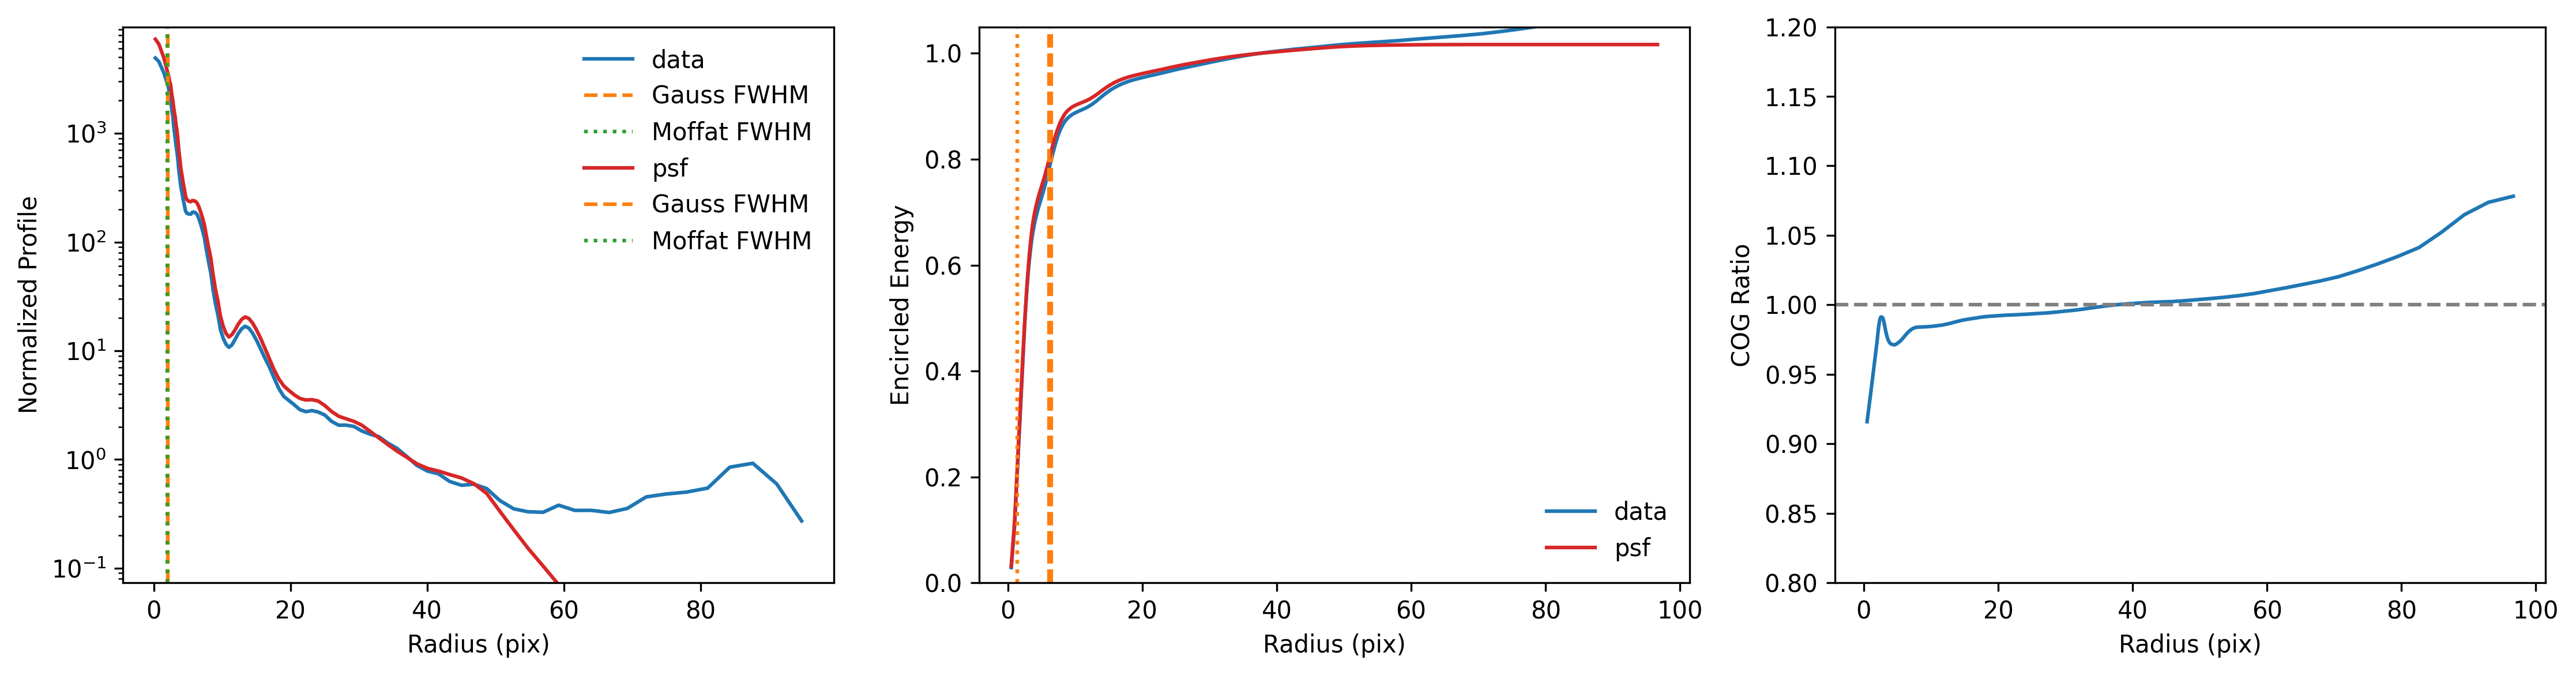

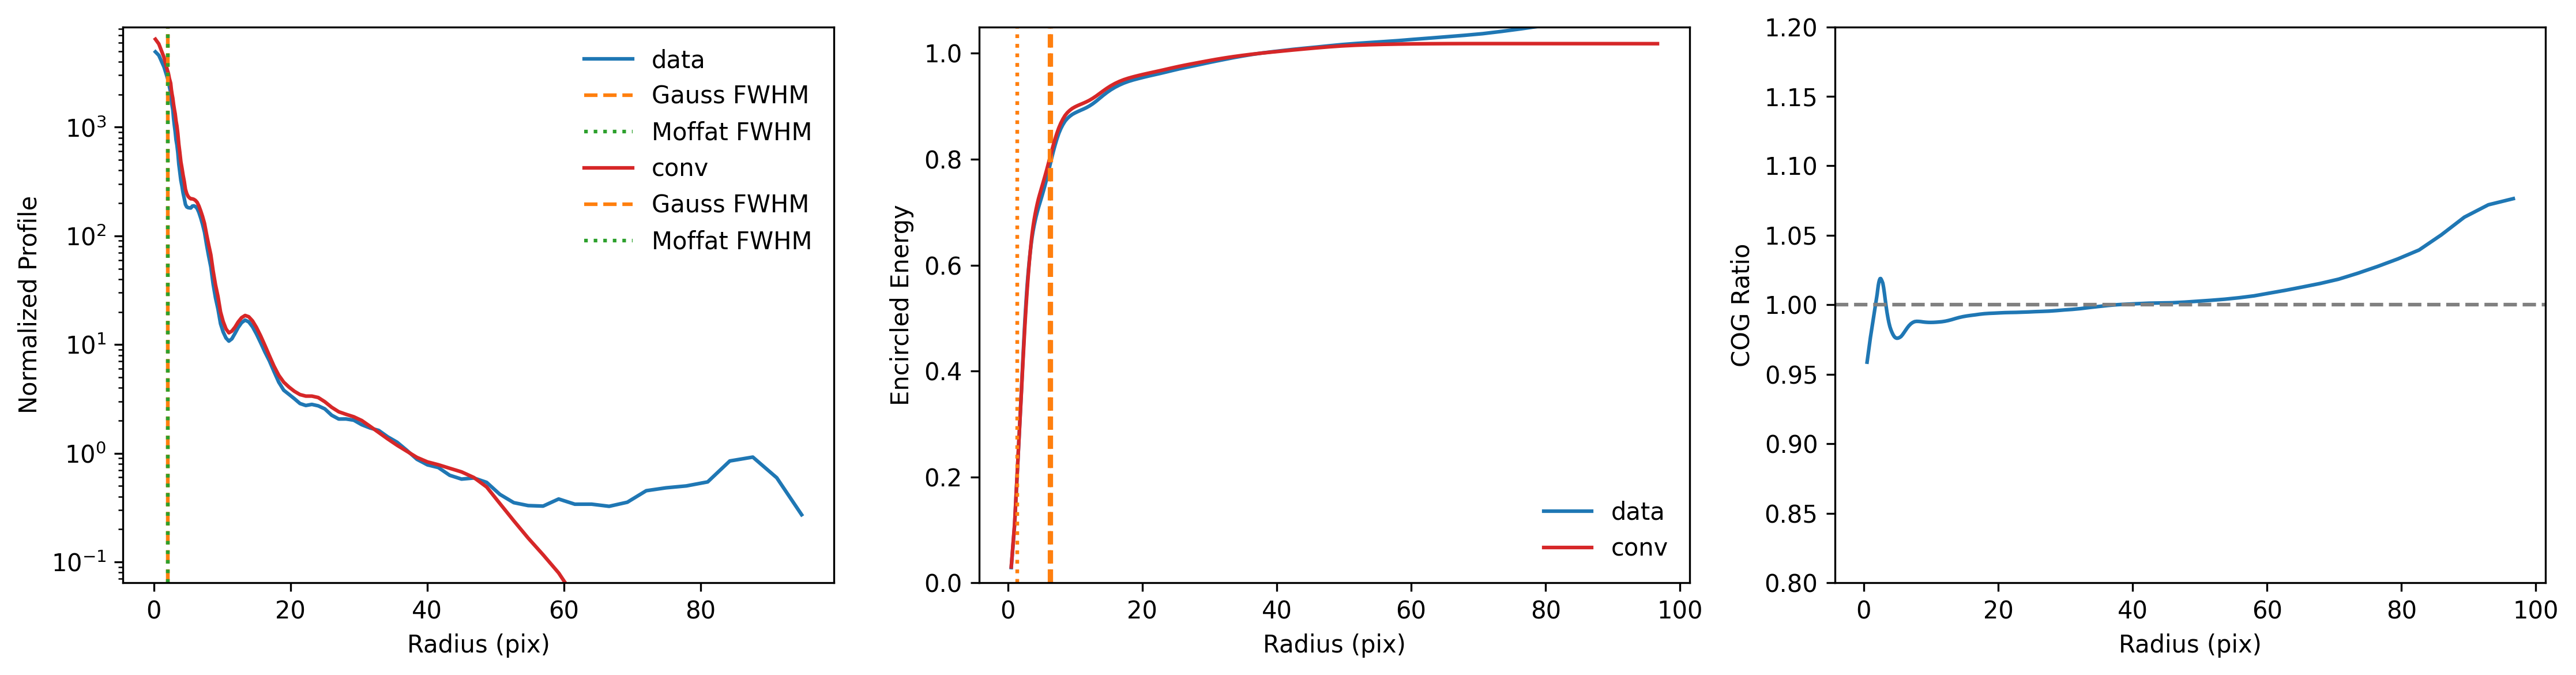

In [54]:
conv = _convolve2d(psf_data, kernel)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
offset = 2e-5
kws = dict(vmin=-5.3, vmax=-1.5, cmap='bone_r', origin='lower')
axes[0].imshow(np.log10(cutout_data/scl + offset), **kws)
axes[1].imshow(np.log10(psf_data + offset), **kws)
axes[2].imshow(np.log10(cutout_data/scl - psf_data + offset), **kws)
axes[3].imshow(np.log10(cutout_data/scl - conv + offset), **kws)
axes[4].imshow(np.log10(kernel + offset), **kws)
plt.show()

rp_data = utils.CircularApertureProfile(cutout_data/scl, name='data', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=True)
rp_psf = utils.CircularApertureProfile(psf_data, name='psf', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=True)
rp_conv = utils.CircularApertureProfile(conv, name='conv', norm_radius = Rnorm_as / dpsf.driz_pscale, recenter=True)
rp_data.plot(compare_to=rp_psf)
rp_data.plot(compare_to=rp_conv)


In [ ]:
dpsf.epsf_obj.

OrderedDict([('STDPSF_MIRI_F770W_EXTENDED',
              array([[[4.4409555e-07, 3.8228737e-07, 3.7919168e-07, ...,
                       4.2764768e-07, 4.0696054e-07, 4.1259898e-07],
                      [6.2138264e-07, 5.5763729e-07, 5.4866604e-07, ...,
                       5.9312197e-07, 5.6977228e-07, 5.7768136e-07],
                      [7.3249157e-07, 6.9551879e-07, 6.7719208e-07, ...,
                       6.9035030e-07, 6.7176836e-07, 6.8080982e-07],
                      ...,
                      [8.8203444e-07, 7.6029545e-07, 8.0721441e-07, ...,
                       8.4356509e-07, 9.8637065e-07, 9.0837921e-07],
                      [7.4313732e-07, 5.9407932e-07, 7.0702731e-07, ...,
                       6.9894327e-07, 8.2430108e-07, 7.0187212e-07],
                      [5.3171681e-07, 4.0098578e-07, 5.1971472e-07, ...,
                       4.9173610e-07, 5.8191688e-07, 4.6714629e-07]],
              
                     [[6.2747864e-07, 5.4107812e-07, 5.388060

In [ ]:
dates = [dpsf.hdrs[k]['MJD-AVG'] for k in dpsf.flt_keys]



In [21]:
du = dpsf.epsf_obj.epsf['UDS_MIRI_F770W']
#de = dpsf.epsf_obj.epsf['STDPSF_MIRI_F770W_EXTENDED']

Cutout size: 201 pixels
Position: [242.94792482 341.70934438], Filter: UDS_NRCA5_F444W, in frame: jw01837002005_08201_00001_nrcalong_rate.fits[SCI,1]
Position: [269.11893802 350.20417296], Filter: UDS_NRCA5_F444W, in frame: jw01837002005_08201_00002_nrcalong_rate.fits[SCI,1]
Position: [1408.23455673  452.34084194], Filter: UDS_NRCA5_F444W, in frame: jw01837034001_09201_00001_nrcalong_rate.fits[SCI,1]
Position: [1434.52045619  460.66437437], Filter: UDS_NRCA5_F444W, in frame: jw01837034001_09201_00002_nrcalong_rate.fits[SCI,1]
Position: [ 171.63145092 1858.34384505], Filter: UDS_NRCB5_F444W, in frame: jw03990064001_05201_00001_nrcblong_rate.fits[SCI,1]
Position: [ 166.06310026 1851.94549923], Filter: UDS_NRCB5_F444W, in frame: jw03990064001_05201_00002_nrcblong_rate.fits[SCI,1]
Position: [ 177.121719   1864.72836844], Filter: UDS_NRCB5_F444W, in frame: jw03990064001_05201_00003_nrcblong_rate.fits[SCI,1]
Position: [1630.83209901 1106.86685963], Filter: UDS_NRCA5_F444W, in frame: jw064800

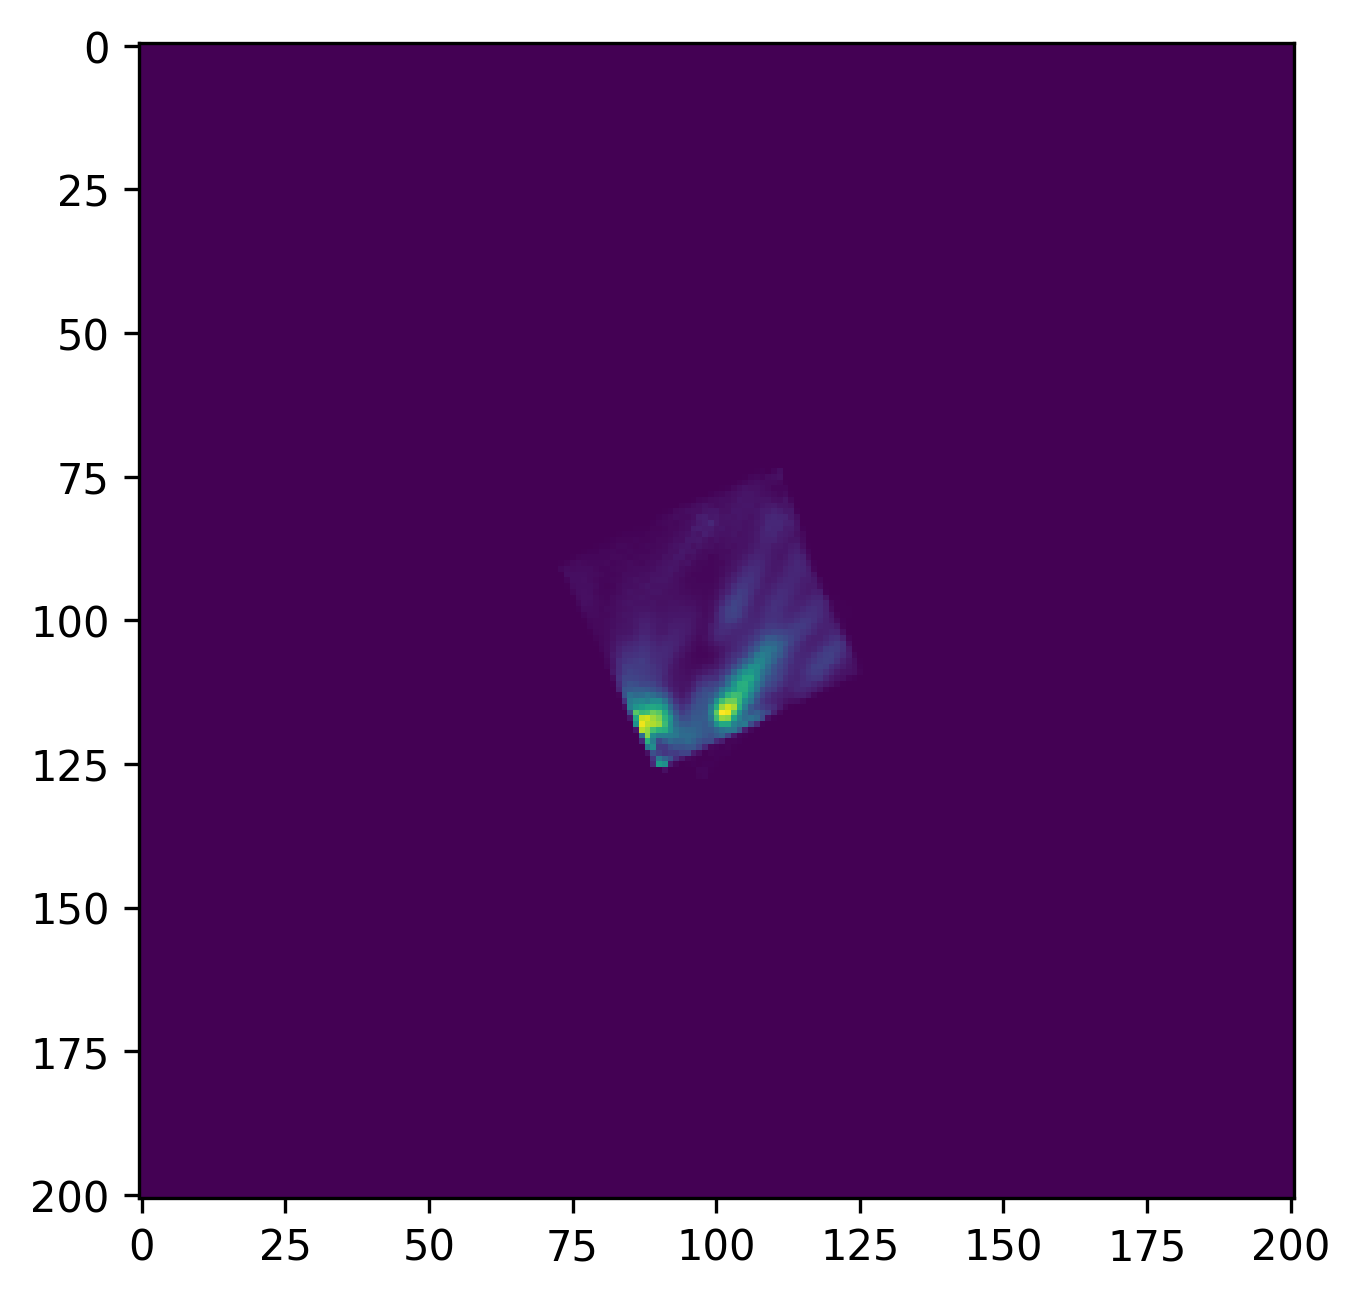

In [29]:
cutout = dpsf.get_driz_cutout(ra, dec, size=size, verbose=True, recenter=True)

psf_data = dpsf.get_psf(
    ra=ra, dec=dec,
    filter=filter_regex, wcs_slice=cutout.wcs,
    kernel=dpsf.driz_header['KERNEL'], pixfrac=dpsf.driz_header['PIXFRAC'],
)
plt.imshow(psf_data)

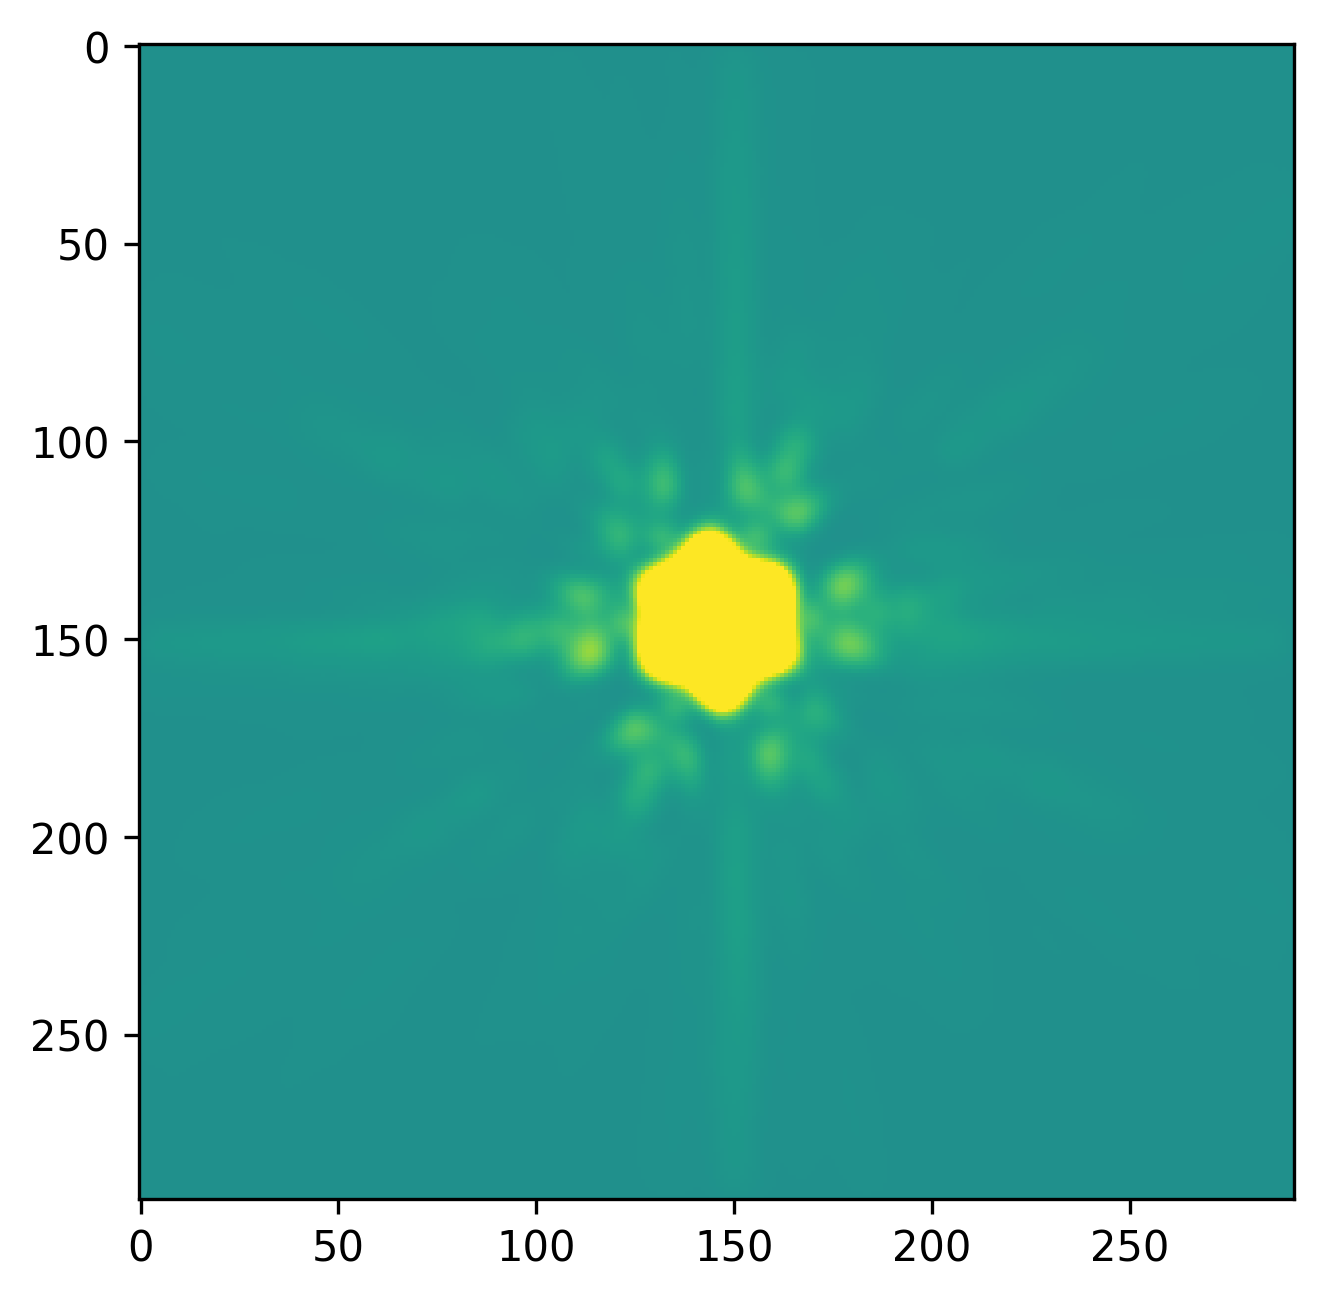

In [37]:
plt.imshow(dpsf.epsf_obj.get_at_position(-100,1,filter='UDS_MIRI_F770W'),vmin=-0.001,vmax=0.001)

In [ ]:
dpsf.epsf_obj.epsf_obj.eval_ePSF

AttributeError: 'EffectivePSF' object has no attribute 'epsf_obj'

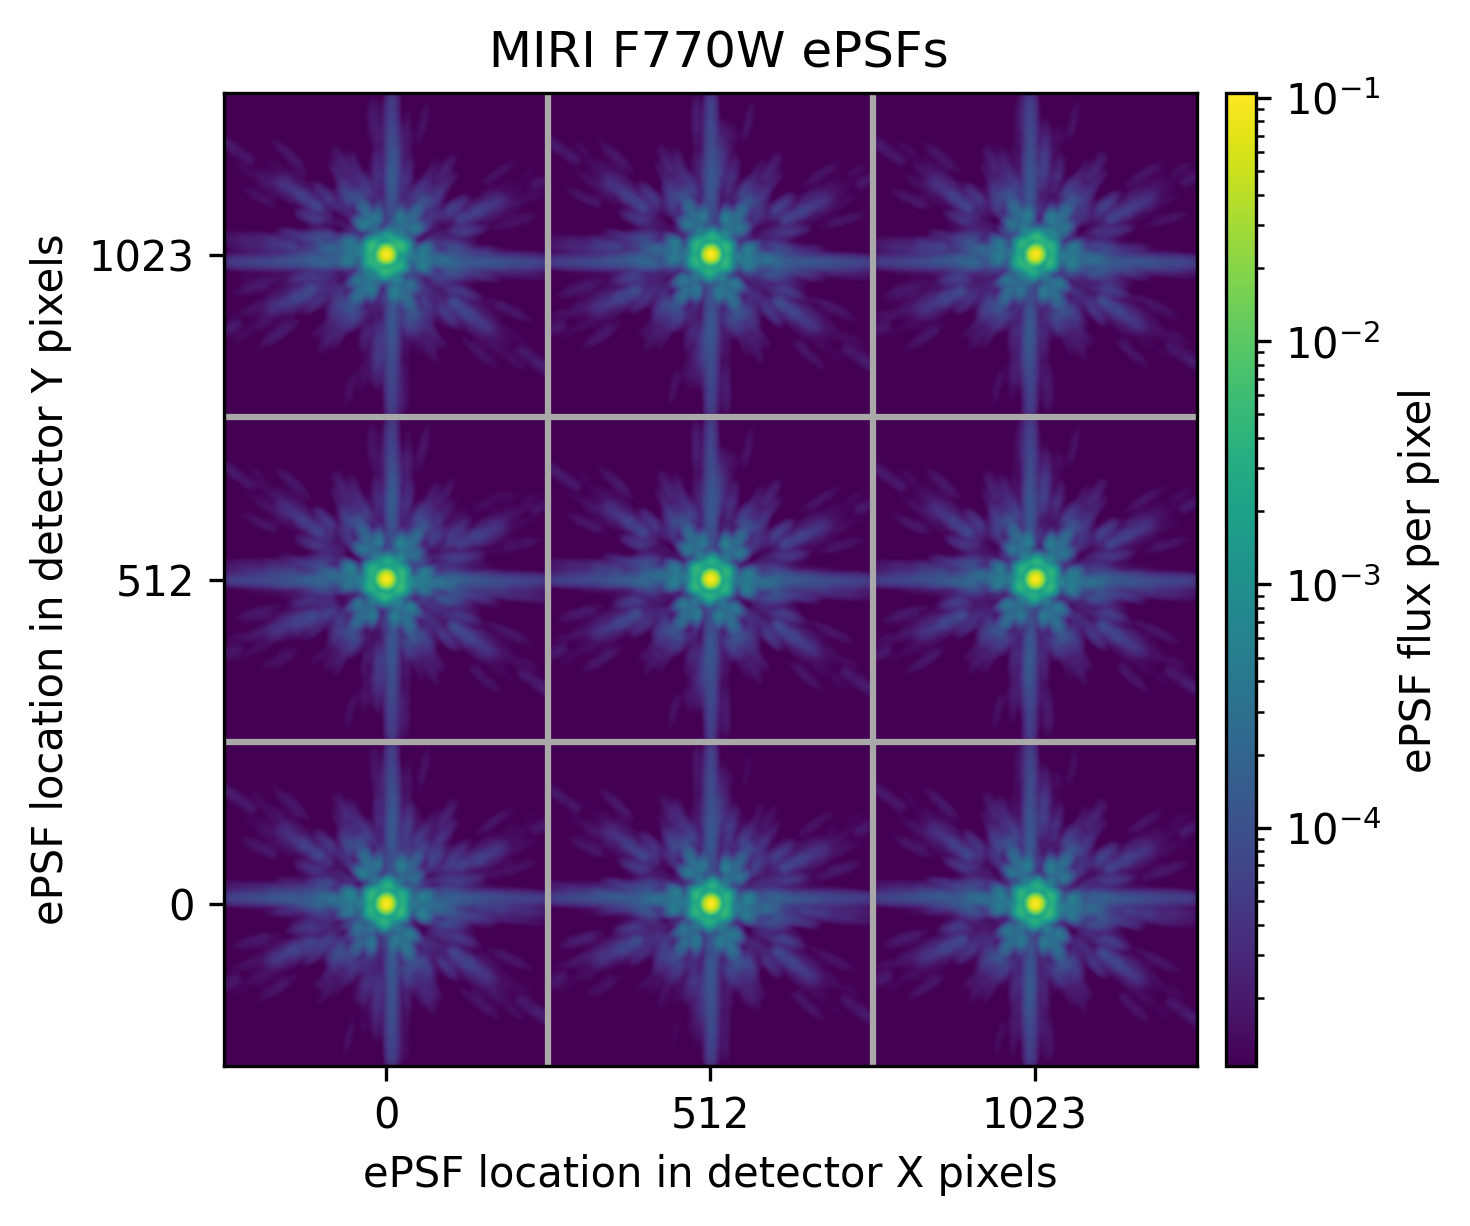

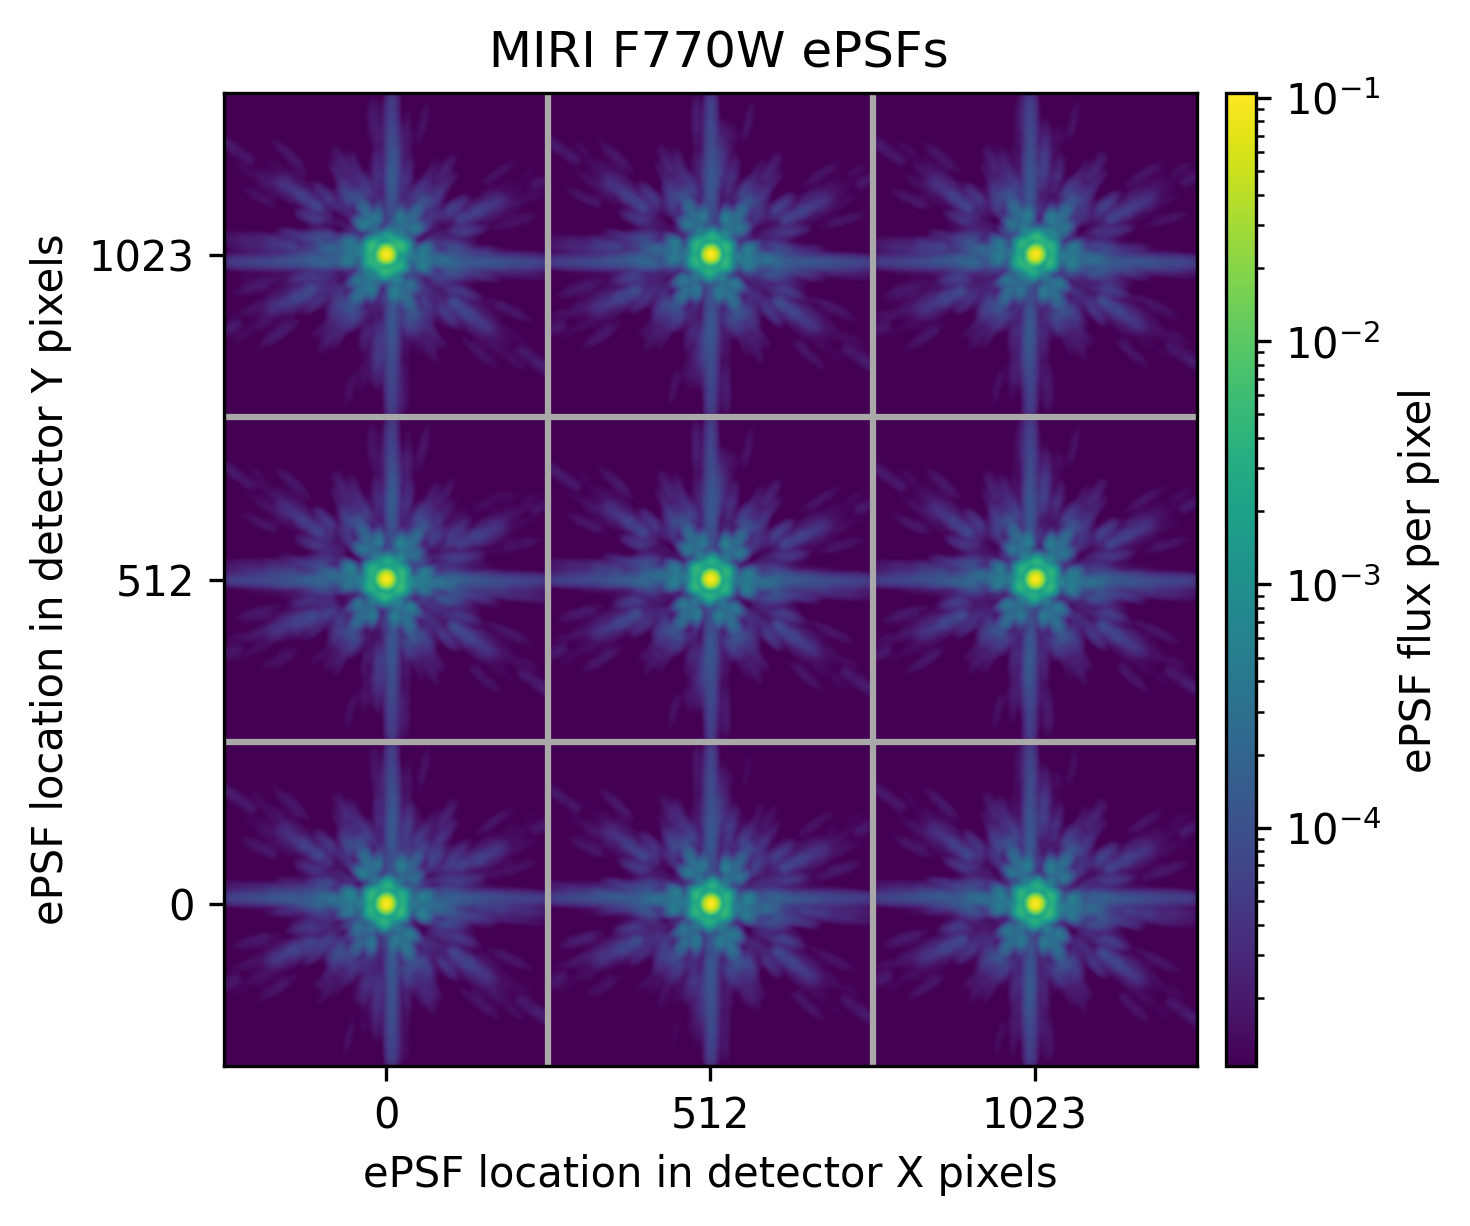

In [32]:
import photutils
#gg = photutils.psf.stdpsf_reader('../data/PSF/STDPSF_MIRI_F770W_EXTENDED.fits')
ggn = photutils.psf.stdpsf_reader('../data/PSF/UDS_MIRI_F770W.fits')
ggn.plot_grid()

In [31]:
ggn.grid_xypos

array([[   0,    0],
       [ 512,    0],
       [1023,    0],
       [   0,  512],
       [ 512,  512],
       [1023,  512],
       [   0, 1023],
       [ 512, 1023],
       [1023, 1023]])

In [17]:
ggn.bounding_box

ModelBoundingBox(
    intervals={
        x: Interval(lower=-36.5, upper=36.5)
        y: Interval(lower=-36.5, upper=36.5)
    }
    model=GriddedPSFModel(inputs=('x', 'y'))
    order='C'
)